In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE

from scipy.special import kl_div
from typing import Union, Any
from scipy.spatial.distance import jensenshannon

In [2]:
BASE = "/mnt/data/kgutjahr/datasets/DVM"
TABLES= os.path.join(BASE, "tables")
FEATURES = os.path.join(BASE, "images")
SHIFTED_DIR = os.path.join(BASE, "shifted_dists", "too_small")

In [3]:
color_coding = {0: 'Beige',
                1: 'Black',
                2: 'Blue', 
                3: 'Bronze', 
                4: 'Brown', 
                5: 'Burgundy', 
                6: 'Gold', 
                7: 'Green', 
                8: 'Grey', 
                9: 'Indigo', 
                10: 'Magenta', 
                11: 'Maroon', 
                12: 'Multicolour', 
                13: 'Navy', 
                14: 'Orange', 
                15: 'Pink', 
                16: 'Purple', 
                17: 'Red', 
                18: 'Silver', 
                19: 'Turquoise', 
                20: 'White', 
                21: 'Yellow'}

In [4]:
def get_counts(df: pd.DataFrame, feature: str, split_value: float = -1.0) -> pd.DataFrame:
    
    if split_value != -1:
        below_or_equal = df[df[feature] <= split_value].shape[0]
        above = df[df[feature] > split_value].shape[0]
        total = below_or_equal + above
        summary = pd.DataFrame({
            'Count': [below_or_equal, above],
            'Percentage': [round(below_or_equal / total * 100, 3), round(above / total * 100, 3)]
        }, index=[f'≤ {split_value}', f'> {split_value}'])
        return summary
    
    counts = df[feature].value_counts()
    percentages = df[feature].value_counts(normalize=True) * 100

    summary = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(3)
    })
    return summary

In [5]:
def plot_distributions(df: pd.DataFrame, feature: str, highlight_dict: dict[int, str] = {}, misc_limit: int = 0, bins: int = 50) -> None:
    plt.figure(figsize=(10, 6))

    if len(df) > 1000:
        df.sort_index(inplace=True)
        counts, bins_edges = np.histogram(df.index, bins=bins)

        # Convert counts to percentage
        percentages = counts / counts.sum() * 100

        # Compute bin centers for correct alignment
        bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2
        bar_widths = np.diff(bins_edges)

        # Plot the histogram manually using bar
        plt.bar(bin_centers, percentages, width=bar_widths, align='center',
                alpha=0.5, label='Train', color='blue', edgecolor='black')
        plt.ylabel('Percentage %')

    else:
        # Step 1: Summarize entries below threshold
        low_count = df[df["Count"] < misc_limit]
        high_count = df[df["Count"] >= misc_limit]

        # Step 2: Add "Miscellaneous" as a new row
        misc_total = low_count["Count"].sum()
        misc_perc = low_count["Percentage"].sum()
        if misc_total > 0:
            misc_row = pd.DataFrame({"Count": [misc_total], "Percentage": [misc_perc]}, index=["Miscellaneous"])
            df_plot = pd.concat([high_count, misc_row])
        else:
            df_plot = high_count.copy()

        ## Step 3: Sort (optional)
        #df_plot = df_plot.sort_values(by="Count", ascending=False)

        # Step 4: Plot
        ax = df_plot["Count"].plot(kind='bar', color='skyblue', edgecolor='black', width=1)
        plt.ylabel('Frequency', fontsize=16)

        # Step 5: Highlight selected bars using the new index
        for i, label in enumerate(df_plot.index):
            if i in highlight_dict:
                ax.patches[i].set_facecolor(highlight_dict[i])
                
            if len(plt.gca().get_xticks()) > 50:
                plt.locator_params(axis='x', nbins=25)

    # Customize the plot
    plt.title(f'{feature} distribution', fontsize=18)
    plt.xlabel(feature, fontsize=16)
    plt.tight_layout()
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)

    # Show the plot
    plt.show()

In [6]:
def plot_compare_distribution(train_dist: Union[pd.Series, pd.DataFrame], val_dist: Union[pd.Series, pd.DataFrame], test_dist: Union[pd.Series, pd.DataFrame], feature: list[Any], feature_name: str) -> None:   
    train_pct = train_dist / train_dist.sum() * 100
    val_pct = val_dist / val_dist.sum() * 100
    test_pct = test_dist / test_dist.sum() * 100
    
    plt.figure(figsize=(12, 6))
    plt.plot(feature, train_pct.reindex(feature), label='Train', marker='o')
    plt.plot(feature, val_pct.reindex(feature), label='Validation', marker='s')
    plt.plot(feature, test_pct.reindex(feature), label='Test', marker='^')
    plt.xticks(rotation=45)
    
    plt.ylabel('% of split')
    plt.title(f'{feature_name} Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_histogram_comparison(train: pd.Series, val: pd.Series, test: pd.Series, feature: str,bins: int = 50) -> None:
    plt.figure(figsize=(10, 6))

    # Plot histograms on the same axis
    plt.hist(train.dropna(), bins=bins, alpha=0.5, label='Train', color='blue', edgecolor='black', weights=np.ones(len(train)) * 100 / len(train))
    plt.hist(val.dropna(),   bins=bins, alpha=0.5, label='Val',   color='red', edgecolor='black', weights=np.ones(len(val)) * 100 / len(val))
    plt.hist(test.dropna(),  bins=bins, alpha=0.5, label='Test',  color='green', edgecolor='black', weights=np.ones(len(test)) * 100 / len(test))

    # Customize
    plt.title(f'{feature} Distribution Comparison')
    plt.xlabel(feature)
    plt.ylabel('% of split')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
def calc_KL(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> np.ndarray:
    first_sorted = first_dist.sort_index()
    second_sorted = second_dist.sort_index()
    kl = np.sum(kl_div(first_sorted, second_sorted))
    return kl

In [9]:
def calc_JS(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> float:
    first_sorted = first_dist.sort_index()
    second_sorted = second_dist.sort_index()
    js = jensenshannon(first_sorted, second_sorted)
    return float(js)

In [10]:
def fill_missing_vals(df: pd.DataFrame, fill_values: list[str]) -> pd.DataFrame:
    # fill missing color with 0 if it isn't present in distribution
    df_copy = df.copy()
    for fill in fill_values:
        if fill not in df_copy:
            df_copy[fill] = 0
    return df_copy

In [11]:
def calc_normalized_dists(count_df: pd.DataFrame) -> pd.DataFrame:
    return count_df['Count'] / count_df['Count'].sum()

# Get entire Dataset

In [12]:
physical_df = pd.read_csv(os.path.join(TABLES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
physical_df

,Adv_ID,Wheelbase,Height,Width,Length
0,10_1$$1,3134.0,1534.0,2118.0,5387.0
1,10_1$$2,3102.0,1551.0,2075.0,5433.0
2,10_1$$3,3122.0,1490.0,2122.0,5369.0
3,10_1$$4,3135.0,1513.0,2094.0,5353.0
4,10_1$$5,3105.0,1514.0,2077.0,5376.0
...,...,...,...,...,...
268250,97_1$$1,NaN,NaN,NaN,NaN
268251,97_1$$2,NaN,NaN,NaN,NaN
268252,99_1$$1,NaN,NaN,NaN,NaN
268253,99_1$$2,NaN,NaN,NaN,NaN


In [13]:
ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]
ad_data

/tmp/ipykernel_638782/3060315506.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]


,Adv_ID,Genmodel,Maker
0,10_1$$1,Arnage,Bentley
1,10_1$$2,Arnage,Bentley
2,10_1$$3,Arnage,Bentley
3,10_1$$4,Arnage,Bentley
4,10_1$$5,Arnage,Bentley
...,...,...,...
268250,97_1$$1,Sport,Westfield
268251,97_1$$2,Sport,Westfield
268252,99_1$$1,E10,Zenos
268253,99_1$$2,E10,Zenos


In [14]:
unique_cars = ad_data.drop_duplicates(subset=["Maker", "Genmodel"]).reset_index(drop=True)
unique_cars['Genmodel_ID'] = unique_cars['Adv_ID'].str.partition('$$')[0]
unique_cars['Car Name'] = unique_cars['Maker'].str.cat(unique_cars['Genmodel'], sep=' ')
unique_cars.drop(["Maker", "Genmodel", "Adv_ID"], axis=1, inplace=True)

unique_cars

,Genmodel_ID,Car Name
0,10_1,Bentley Arnage
1,10_2,Bentley Azure
2,10_3,Bentley Bentayga
3,10_4,Bentley Brooklands
4,10_5,Bentley Continental
...,...,...
911,96_7,Volvo V40
912,96_8,Volvo V40 Cross Country
913,96_9,Volvo V50
914,97_1,Westfield Sport


In [15]:
data_path = os.path.join(FEATURES, "data_df_unnorm.csv")
full_data_df = pd.read_csv(data_path)
full_data_df = full_data_df.loc[:, ~full_data_df.columns.str.contains('^Unnamed')]

In [16]:
minimum_population = 100
values = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(codes[i][0])
    
full_data_df = full_data_df[full_data_df['Genmodel_ID'].isin(populated_codes)]

In [17]:
full_data_df = full_data_df.merge(physical_df, on='Adv_ID')
full_data_df.dropna(inplace=True)
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,...,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint,Wheelbase,Height,Width,Length
0,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225,2981.0,1746.0,2185.0,5123.0
1,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,2953.0,1699.0,2268.0,5184.0
2,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225,2974.0,1715.0,2257.0,5130.0
3,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,3031.0,1788.0,2184.0,5130.0
4,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,3006.0,1727.0,2237.0,5154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176409,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2591.0,1496.0,1762.0,4471.0
176410,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,...,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2618.0,1449.0,1753.0,4536.0
176411,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2627.0,1467.0,1722.0,4509.0
176412,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,...,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,2673.0,1457.0,1767.0,4512.0


In [18]:
list(full_data_df.columns)

['Adv_ID',
 'Adv_year',
 'Adv_month',
 'Reg_year',
 'Runned_Miles',
 'Price',
 'Seat_num',
 'Door_num',
 'Entry_price',
 'Engine_size',
 'Color',
 'Bodytype',
 'Gearbox',
 'Fuel_type',
 'Genmodel_ID',
 'Image_name',
 'Predicted_viewpoint',
 'Wheelbase',
 'Height',
 'Width',
 'Length']

### Plot entire Distribution

In [19]:
color_counts = get_counts(df=full_data_df, feature="Color")
color_counts

,Count,Percentage
Black,34005,19.276
Silver,29902,16.950
Blue,27793,15.754
Grey,26150,14.823
White,23369,13.247
Red,19514,11.061
Green,3500,1.984
Brown,2300,1.304
Yellow,2233,1.266
Orange,1966,1.114


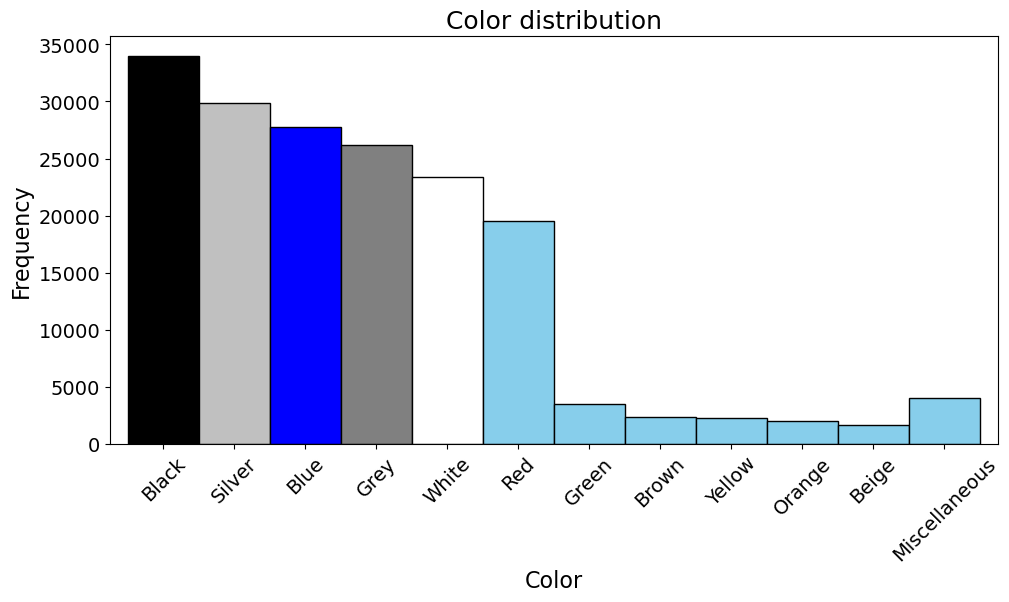

In [20]:
plot_distributions(df=color_counts, feature="Color", highlight_dict={0: "black", 1: "silver", 2: "blue", 3: "grey", 4: "white"}, misc_limit=1200)

## Get Original Splits

In [21]:
def recreate_original_split(full_data: pd.DataFrame, split_path: str) -> pd.DataFrame:
    split_df = pd.read_csv(split_path)
    split_df_ids = list(split_df["Adv_ID"])
    return full_data[full_data["Adv_ID"].isin(split_df_ids)].reset_index(drop=True)

In [22]:
train_df_path = os.path.join(SHIFTED_DIR, "black", f'dvm_features_train.csv')
train_df = pd.read_csv(train_df_path, header=None)
#train_df = recreate_original_split(full_data=full_data_df, split_path=train_df_path)

val_df_path = os.path.join(SHIFTED_DIR, "black", f'dvm_features_val.csv')
val_df = pd.read_csv(val_df_path, header=None)
#val_df = recreate_original_split(full_data=full_data_df, split_path=val_df_path)

test_df_path = os.path.join(SHIFTED_DIR, "black", f'dvm_features_test.csv')
test_df = pd.read_csv(test_df_path, header=None)
#test_df = recreate_original_split(full_data=full_data_df, split_path=test_df_path)

In [23]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

print(f"Total Size: {train_df.shape[0] + val_df.shape[0] + test_df.shape[0]}")

(29000, 17)
(4999, 17)
(4992, 17)
Total Size: 38991


## Plot Color Distribution of splits

### Training Split

In [25]:
bl_color_coding = {0: 'Black',
 1: 'Grey',
 2: 'Silver',
 3: 'Blue',
 4: 'White',
 5: 'Brown',
 6: 'Red',
 7: 'Purple',
 8: 'Beige',
 9: 'Green',
 10: 'Yellow',
 11: 'Orange',
 12: 'Bronze',
 13: 'Turquoise',
 14: 'Pink',
 15: 'Multicolour',
 16: 'Gold'}

train_color_counts = get_counts(df=train_df, feature=0)
train_color_counts.index = train_color_counts.index.map(bl_color_coding)
train_color_counts

,Count,Percentage
Black,29000,100.0


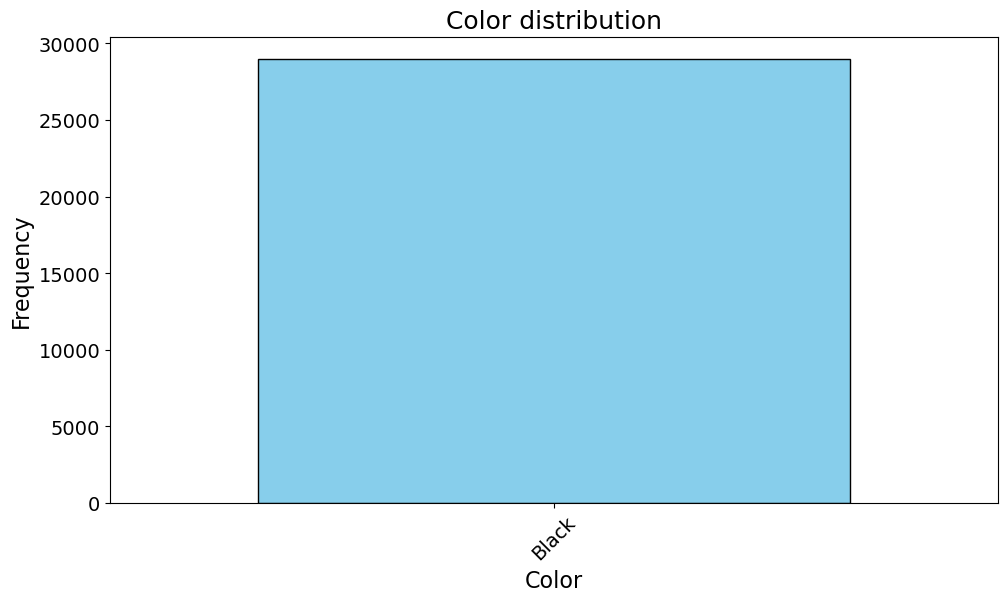

In [26]:
plot_distributions(df=train_color_counts, feature="Color")

### Validation Split

In [28]:
val_color_counts = get_counts(df=val_df, feature=0)
val_color_counts.index = val_color_counts.index.map(bl_color_coding)
val_color_counts

,Count,Percentage
Black,4999,100.0


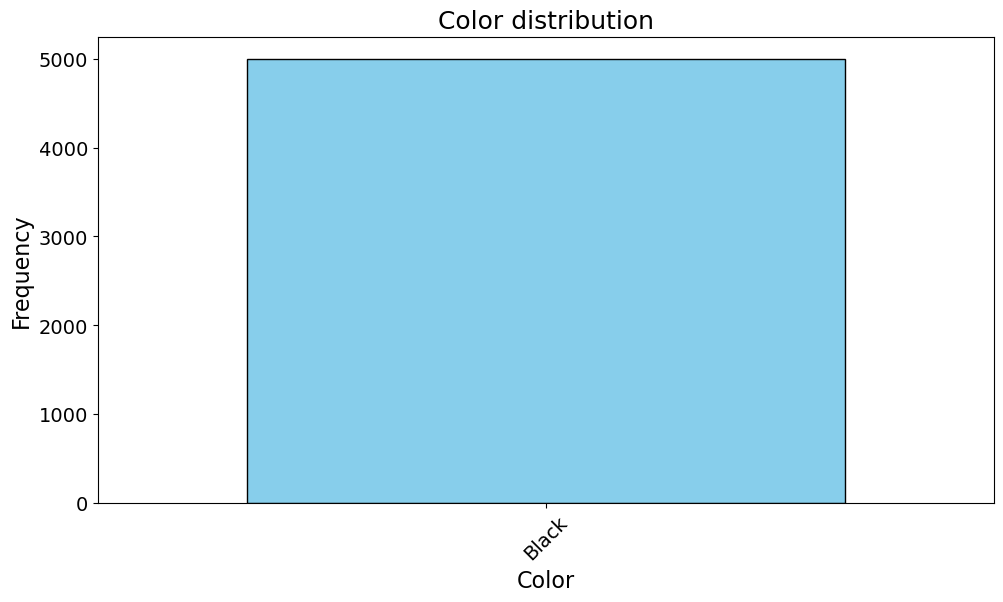

In [29]:
plot_distributions(df=val_color_counts, feature="Color")

### Test Split

In [31]:
test_color_counts = get_counts(df=test_df, feature=0)
test_color_counts.index = test_color_counts.index.map(bl_color_coding)
test_color_counts

,Count,Percentage
Silver,1096,21.955
Blue,984,19.712
Grey,921,18.450
White,805,16.126
Red,670,13.421
Green,127,2.544
Brown,68,1.362
Orange,64,1.282
Yellow,62,1.242
Beige,60,1.202


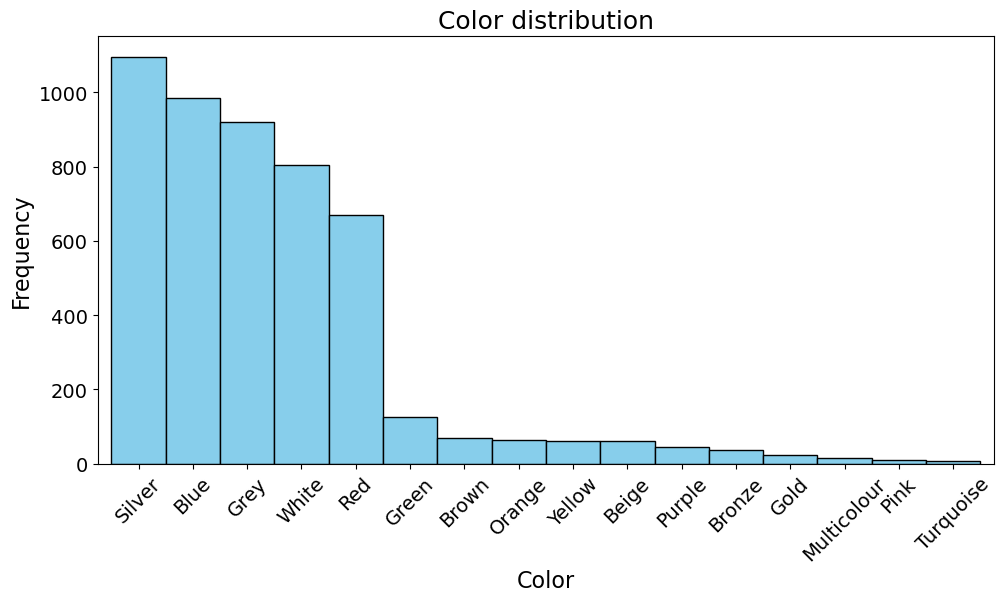

In [32]:
plot_distributions(df=test_color_counts, feature="Color")

## Compare original color distribution

In [33]:
colors = list(color_coding.values())

In [34]:
train_color_dist = calc_normalized_dists(count_df=train_color_counts)
val_color_dist = calc_normalized_dists(count_df=val_color_counts)
test_color_dist = calc_normalized_dists(count_df=test_color_counts)

In [35]:
train_df_filled = fill_missing_vals(df=train_color_dist, fill_values=colors)
val_df_filled = fill_missing_vals(df=val_color_dist, fill_values=colors)
test_df_filled = fill_missing_vals(df=test_color_dist, fill_values=colors)

In [36]:
train_val_kl_color = calc_KL(first_dist=train_color_dist, second_dist=val_color_dist)
train_val_kl_color

0.0

In [37]:
train_test_kl = calc_KL(first_dist=train_color_dist, second_dist=test_color_dist)
train_test_kl

0.0

In [38]:
train_val_js = calc_JS(first_dist=train_df_filled, second_dist=val_df_filled)
train_val_js

0.0

In [39]:
train_test_js = calc_JS(first_dist=train_df_filled, second_dist=test_df_filled)
train_test_js

0.8325546111576977

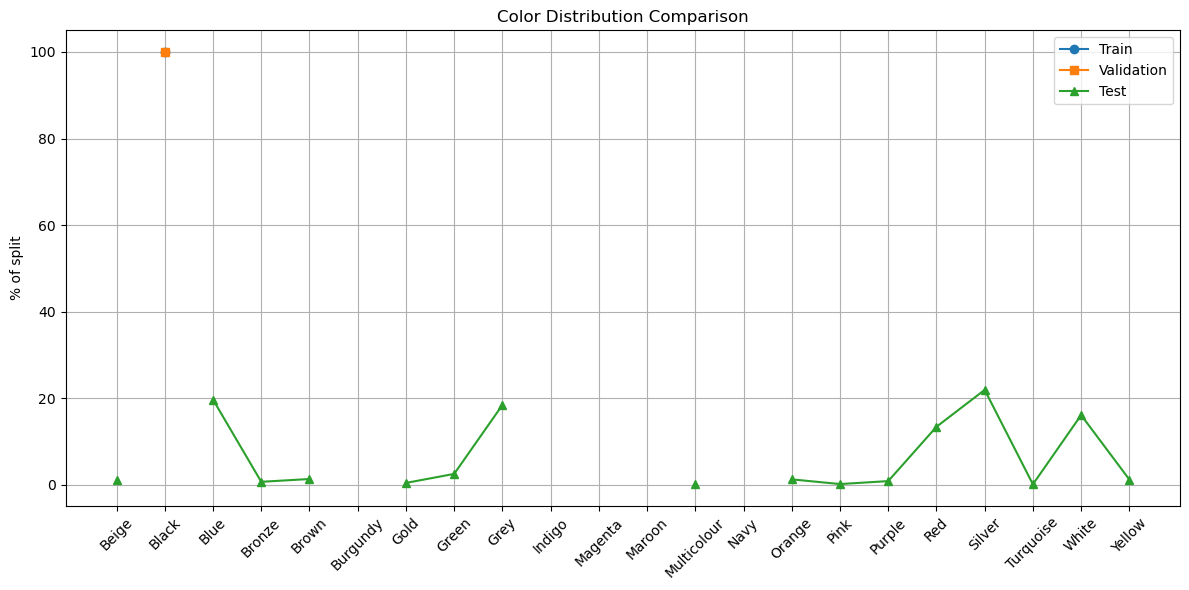

In [40]:
plot_compare_distribution(train_dist=train_color_dist, val_dist=val_color_dist, test_dist=test_color_dist, feature=colors, feature_name="Color")

In [41]:
list(full_data_df.columns)

['Adv_ID',
 'Adv_year',
 'Adv_month',
 'Reg_year',
 'Runned_Miles',
 'Price',
 'Seat_num',
 'Door_num',
 'Entry_price',
 'Engine_size',
 'Color',
 'Bodytype',
 'Gearbox',
 'Fuel_type',
 'Genmodel_ID',
 'Image_name',
 'Predicted_viewpoint',
 'Wheelbase',
 'Height',
 'Width',
 'Length']

## Non-Image-based Properties

#### Price

In [43]:
price_counts = get_counts(df=full_data_df, feature="Entry_price")
price_counts

,Count,Percentage
8940,2751,1.559
9940,1354,0.768
7940,1286,0.729
9440,1249,0.708
12940,1043,0.591
...,...,...
20585,1,0.001
25165,1,0.001
13895,1,0.001
15819,1,0.001


In [41]:
from numpy import median

median(list(price_counts.index))

17895.0

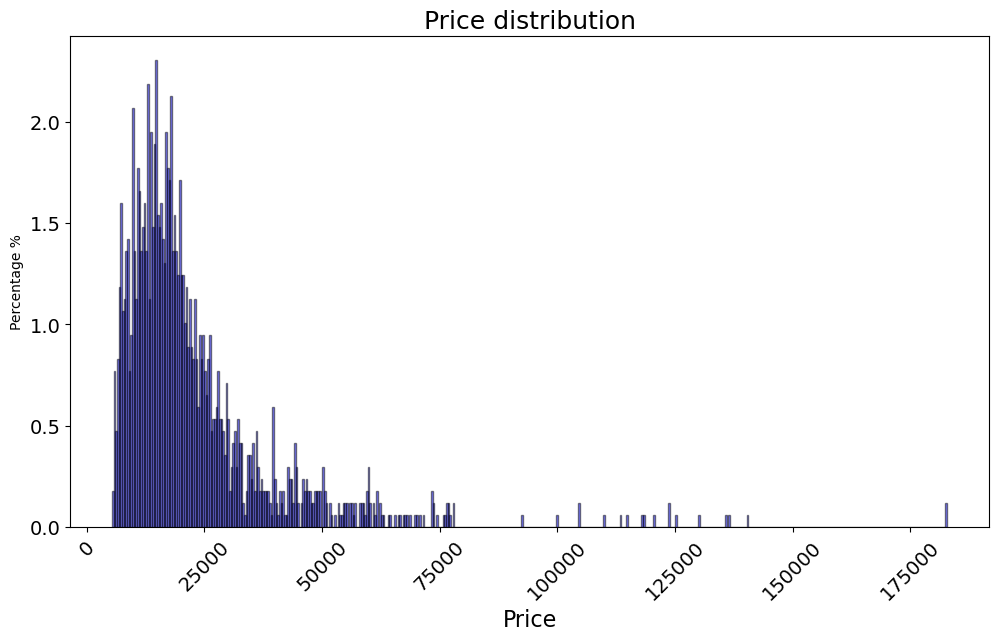

In [42]:
plot_distributions(df=price_counts, feature="Price", bins=500)

In [43]:
quartiles = np.percentile(full_data_df["Entry_price"], [25, 50, 75])
print(quartiles)

[11090. 16260. 22790.]


In [44]:
train_price_counts = get_counts(df=train_df, feature=11)
train_price_counts.head(5)

,Count,Percentage
-0.789460,390,1.345
-0.848038,174,0.600
-0.317910,168,0.579
-0.771301,165,0.569
-0.730882,163,0.562


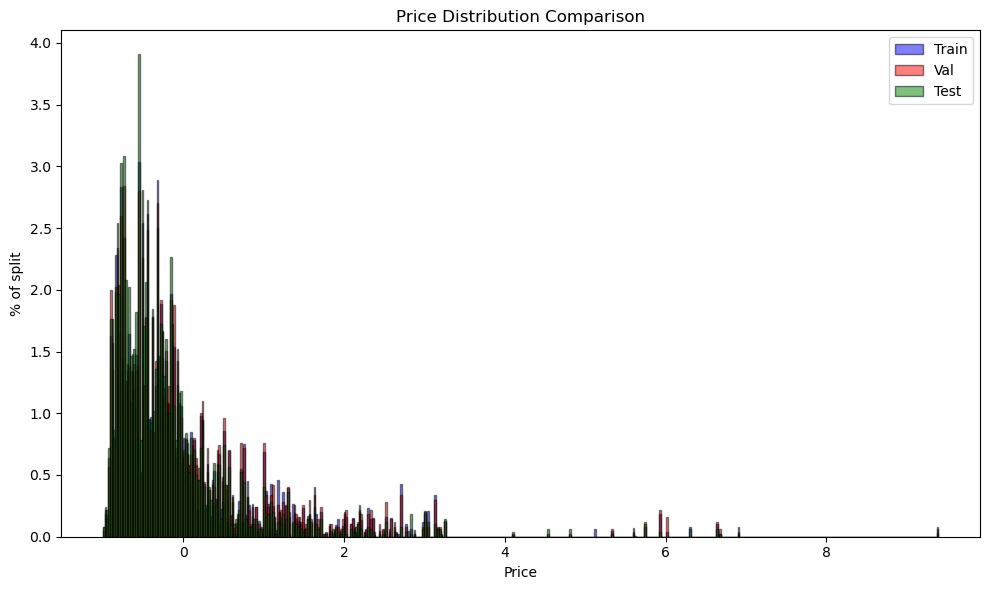

In [45]:
plot_histogram_comparison(train=train_df[11], val=val_df[11], test=test_df[11], feature="Price", bins=500)

In [46]:
price_median_counts = get_counts(df=full_data_df, feature="Entry_price", split_value=full_data_df["Entry_price"].median())
price_median_counts

,Count,Percentage
≤ 16260.0,88371,50.093
> 16260.0,88043,49.907


In [47]:
quartiles = np.percentile(full_data_df["Entry_price"], [25, 50, 75])
print(quartiles)

[11090. 16260. 22790.]


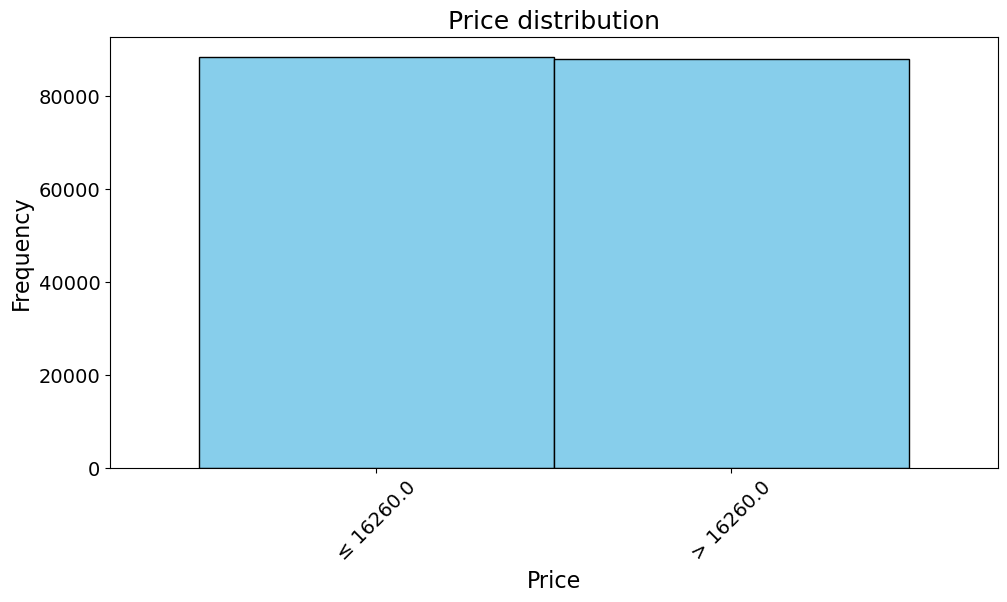

In [48]:
plot_distributions(df=price_median_counts, feature="Price", bins=100)

#### Gearbox

In [47]:
gearbox_counts = get_counts(df=full_data_df, feature="Gearbox")
gearbox_counts

,Count,Percentage
Manual,118882,67.388
Automatic,57512,32.601
Semi-Automatic,20,0.011


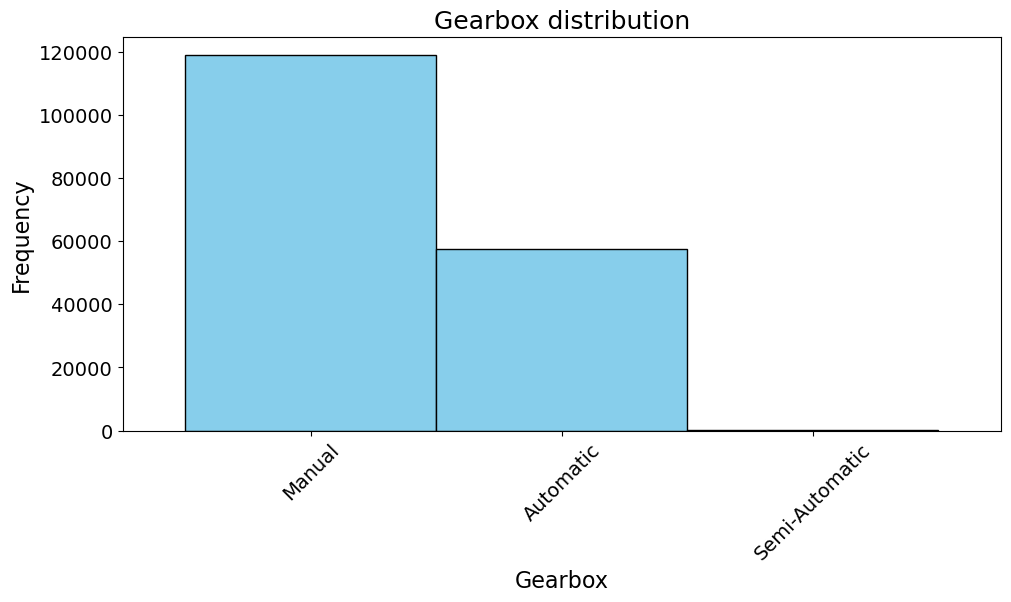

In [48]:
plot_distributions(df=gearbox_counts, feature="Gearbox")

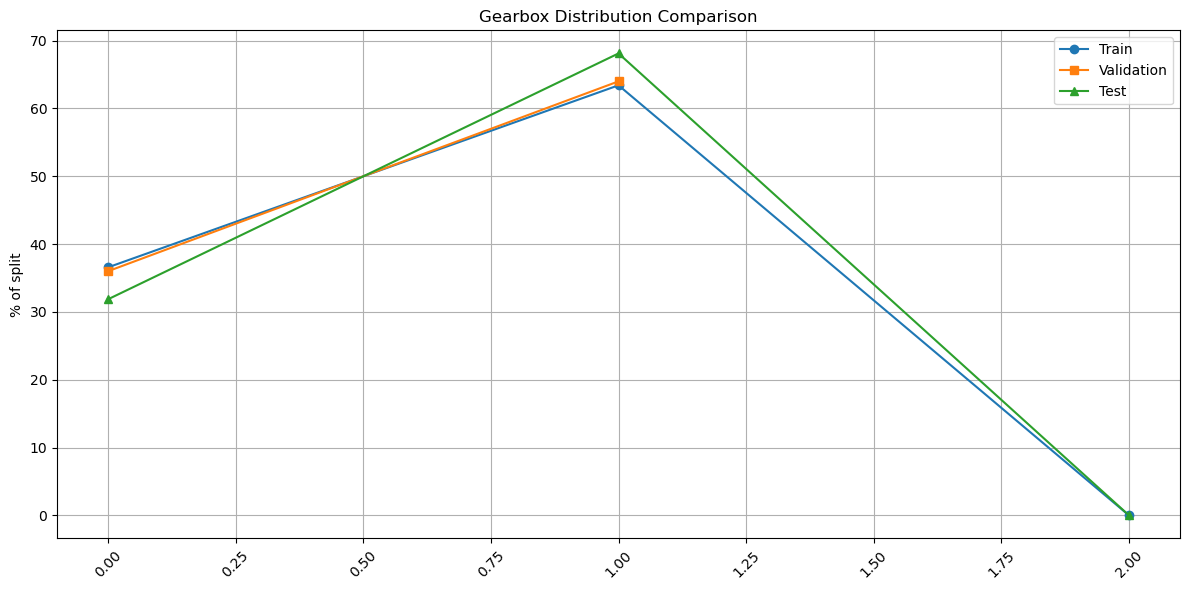

In [54]:
train_gearbox_counts = get_counts(df=train_df, feature=2)
val_gearbox_counts = get_counts(df=val_df, feature=2)
test_gearbox_counts = get_counts(df=test_df, feature=2)

train_gearbox_norm = calc_normalized_dists(count_df=train_gearbox_counts)
val_gearbox_norm = calc_normalized_dists(count_df=val_gearbox_counts)
test_gearbox_norm = calc_normalized_dists(count_df=test_gearbox_counts)

plot_compare_distribution(train_dist=train_gearbox_norm, val_dist=val_gearbox_norm, test_dist=test_gearbox_norm, feature=sorted(list(train_gearbox_counts.index)), feature_name="Gearbox")

#### Fuel Type

In [55]:
fuel_counts = get_counts(df=full_data_df, feature="Fuel_type")
fuel_counts

,Count,Percentage
Diesel,87084,49.363
Petrol,84920,48.137
Hybrid Petrol/Electric,3521,1.996
Hybrid Petrol/Electric Plug-in,687,0.389
Hybrid Diesel/Electric,81,0.046
Petrol Hybrid,46,0.026
Hybrid Diesel/Electric Plug-in,34,0.019
Petrol Plug-in Hybrid,19,0.011
Bi Fuel,13,0.007
Petrol Ethanol,6,0.003


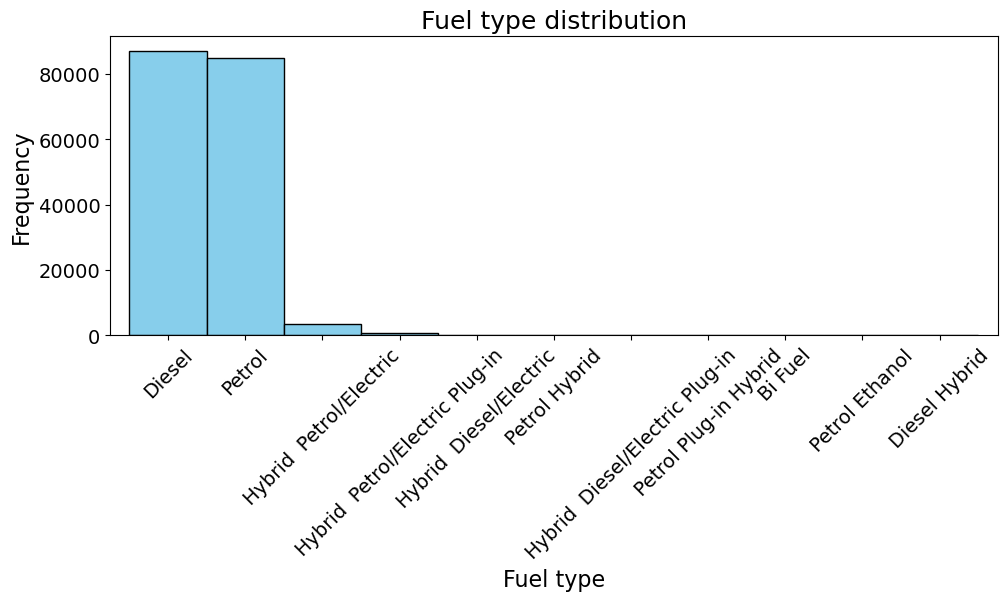

In [56]:
plot_distributions(df=fuel_counts, feature="Fuel type")

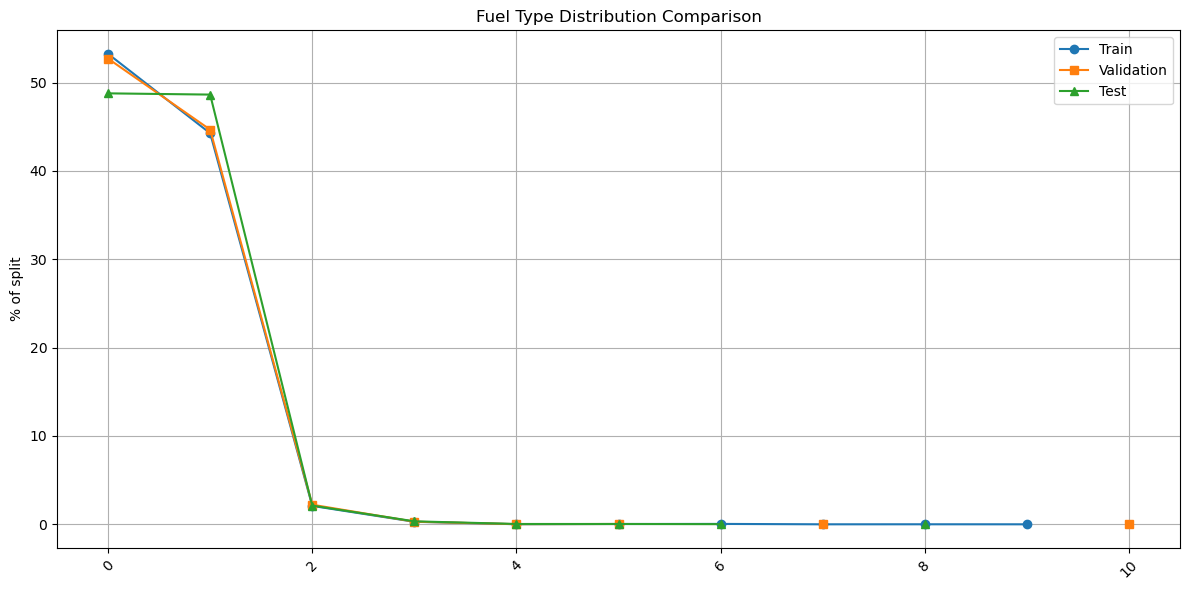

In [57]:
train_fuel_counts = get_counts(df=train_df, feature=3)
val_fuel_counts = get_counts(df=val_df, feature=3)
test_fuel_counts = get_counts(df=test_df, feature=3)

train_fuel_norm = calc_normalized_dists(count_df=train_fuel_counts)
val_fuel_norm = calc_normalized_dists(count_df=val_fuel_counts)
test_fuel_norm = calc_normalized_dists(count_df=test_fuel_counts)

plot_compare_distribution(train_dist=train_fuel_norm, val_dist=val_fuel_norm, test_dist=test_fuel_norm, feature=sorted(list(train_df.index)), feature_name="Fuel Type")

#### Year

In [58]:
year_counts = get_counts(df=full_data_df, feature="Adv_month")
year_counts

,Count,Percentage
5,38787,21.986
8,37356,21.175
7,27689,15.695
4,25388,14.391
6,18201,10.317
3,13633,7.728
2,6107,3.462
1,3602,2.042
12,1686,0.956
11,1661,0.942


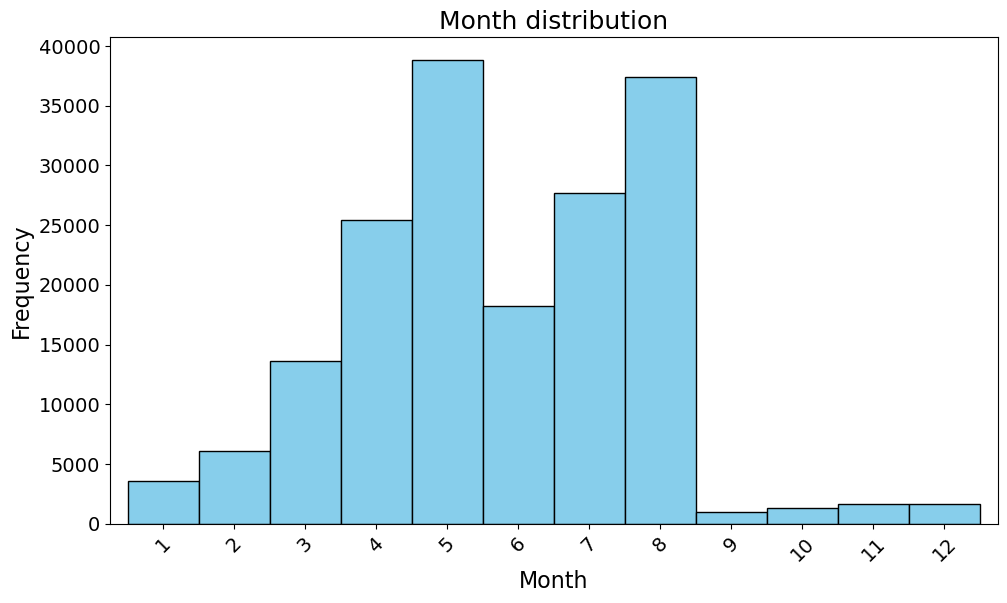

In [59]:
plot_distributions(df=year_counts.reindex(sorted(year_counts.index)), feature="Month")

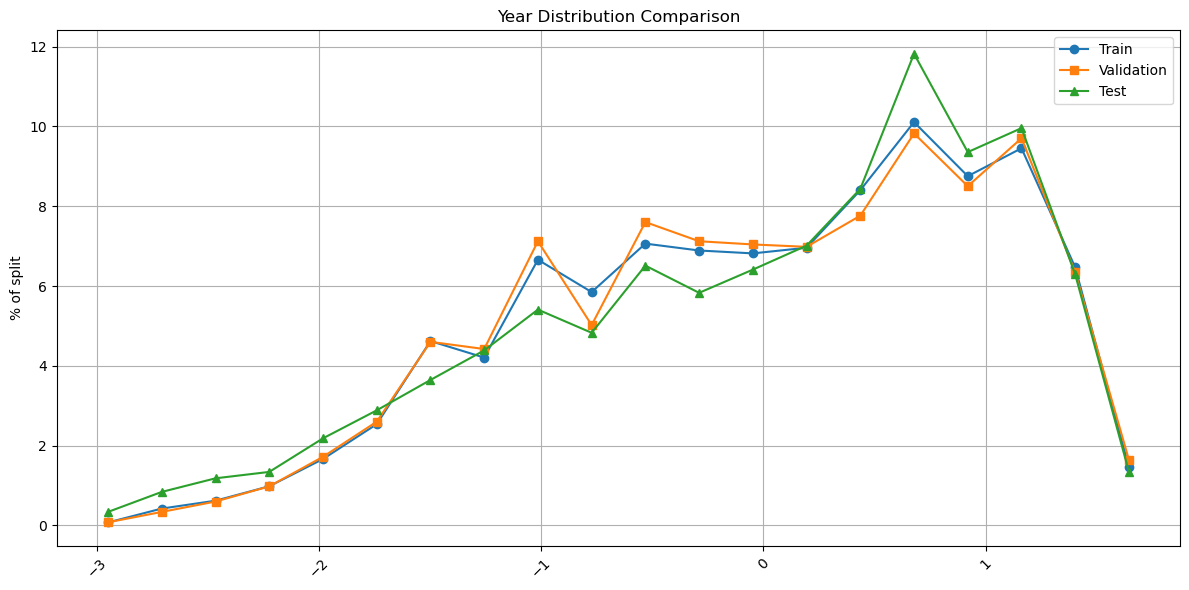

In [64]:
train_year_counts = get_counts(df=train_df, feature=6)
val_year_counts = get_counts(df=val_df, feature=6)
test_year_counts = get_counts(df=test_df, feature=6)

train_year_norm = calc_normalized_dists(count_df=train_year_counts)
val_year_norm = calc_normalized_dists(count_df=val_year_counts)
test_year_norm = calc_normalized_dists(count_df=test_year_counts)

plot_compare_distribution(train_dist=train_year_norm, val_dist=val_year_norm, test_dist=test_year_norm, feature=sorted(list(train_year_counts.index)), feature_name="Year")

In [65]:
quartiles = np.percentile(full_data_df["Reg_year"], [25, 50, 75])
print(quartiles)

[2009. 2013. 2016.]


#### Runned Miles

In [66]:
miles_counts = get_counts(df=full_data_df, feature="Runned_Miles")
sum(miles_counts[miles_counts["Count"] > 100]["Count"].values)

66642

In [67]:
miles_count = miles_counts.sort_index()
miles_count

,Count,Percentage
0,32,0.018
2,42,0.024
3,24,0.014
4,19,0.011
5,296,0.168
...,...,...
880000,1,0.001
900000,1,0.001
967515,1,0.001
1080000,1,0.001


/tmp/ipykernel_638782/1293982489.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


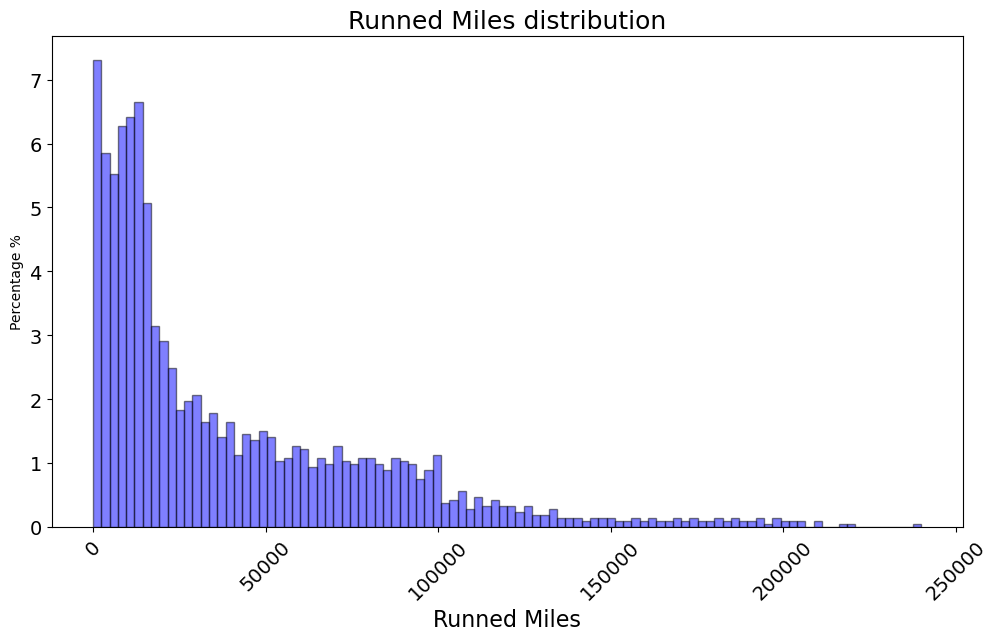

In [68]:
plot_distributions(df=miles_counts[miles_counts["Count"] >= 5], feature="Runned Miles", bins=100)

In [69]:
quartiles = np.percentile(full_data_df["Runned_Miles"], [25, 50, 75])
print(quartiles)

[17038. 44360. 79000.]


In [70]:
print(min(list(miles_counts.index)))
print(max(list(miles_counts.index)))

0
6363342


In [71]:
full_data_df[full_data_df["Runned_Miles"] > 6000000][["Runned_Miles", "Image_name"]]

,Runned_Miles,Image_name
161074,6363342,Volkswagen$$Golf$$2007$$Black$$95_15$$993$$ima...


In [88]:
def plot_histogram_comparison(train: pd.Series, val: pd.Series, test: pd.Series, feature: str,bins: int = 50) -> None:
    plt.figure(figsize=(10, 6))

    # Plot histograms on the same axis
    plt.hist(train.dropna(), bins=bins, alpha=0.5, label='Train', color='blue', edgecolor='black', weights=np.ones(len(train)) * 100 / len(train))
    plt.hist(val.dropna(),   bins=bins, alpha=0.5, label='Val',   color='red', edgecolor='black', weights=np.ones(len(val)) * 100 / len(val))
    plt.hist(test.dropna(),  bins=bins, alpha=0.5, label='Test',  color='green', edgecolor='black', weights=np.ones(len(test)) * 100 / len(test))

    # Customize
    plt.title(f'{feature} Distribution', fontsize=18)
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('% of split', fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()
    
def denormalize_column(df: pd.DataFrame, column: str, means: pd.Series, stds: pd.Series) -> pd.Series:
    mean = means[column]
    std = stds[column]
    col = df[column] * std + mean
    return col.reset_index(drop=True)


mean = pd.Series({
    'Adv_year': 2017.998759,
    'Adv_month': 5.763448,
    'Reg_year': 2012.196552,
    'Runned_Miles': 55156.471241,
    'Price': 13237.241931,
    'Seat_num': 4.897138,
    'Door_num': 4.378034,
    'Entry_price': 22417.160103,
    'Engine_size': 1.981348,
    'Wheelbase': 2659.443138,
    'Height': 1539.072207,
    'Width': 1900.081448,
    'Length': 4390.959931
})

std = pd.Series({
    'Adv_year': 0.415897,
    'Adv_month': 2.063622,
    'Reg_year': 4.133758,
    'Runned_Miles': 55449.686035,
    'Price': 16577.161439,
    'Seat_num': 0.843328,
    'Door_num': 0.995639,
    'Entry_price': 17071.366418,
    'Engine_size': 0.826127,
    'Wheelbase': 190.847386,
    'Height': 130.441778,
    'Width': 156.621383,
    'Length': 430.652694
})

,Count,Percentage
-0.994532,258,0.890
0.808725,232,0.800
0.448037,178,0.614
0.087350,177,0.610
0.267694,169,0.583
...,...,...
0.330561,1,0.003
1.635240,1,0.003
-0.721347,1,0.003
-0.013679,1,0.003


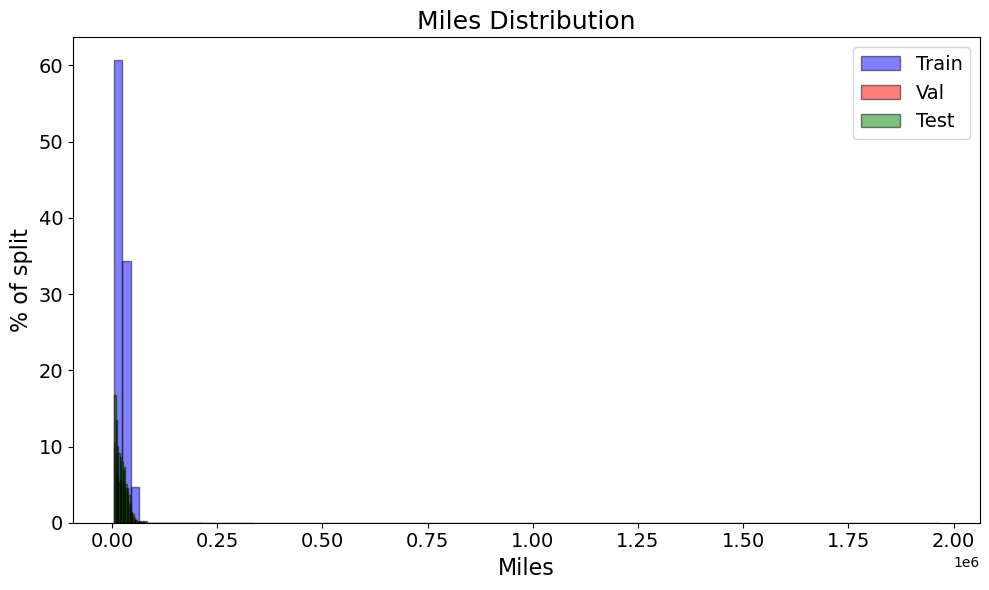

In [90]:
train_year_counts = get_counts(df=train_df, feature=7)
val_year_counts = get_counts(df=val_df, feature=7)
test_year_counts = get_counts(df=test_df, feature=7)

train_month_denorm_df = denormalize_column(df=train_df, column=7, means=mean, stds=std)
display(train_year_counts)
val_month_denorm_df = denormalize_column(df=val_df, column=7, means=mean, stds=std)
test_month_denorm_df = denormalize_column(df=test_df, column=7, means=mean, stds=std)

plot_histogram_comparison(train=train_month_denorm_df, val=val_month_denorm_df, test=test_month_denorm_df, feature="Miles", bins=100)

#### Engine Size

In [72]:
engine_counts = get_counts(df=full_data_df, feature="Engine_size")
engine_counts

,Count,Percentage
2.00,38876,22.037
1.60,31772,18.010
1.20,16728,9.482
1.40,15028,8.519
3.00,12879,7.300
1.00,11246,6.375
1.50,10038,5.690
2.20,5724,3.245
1.80,5078,2.878
2.50,2778,1.575


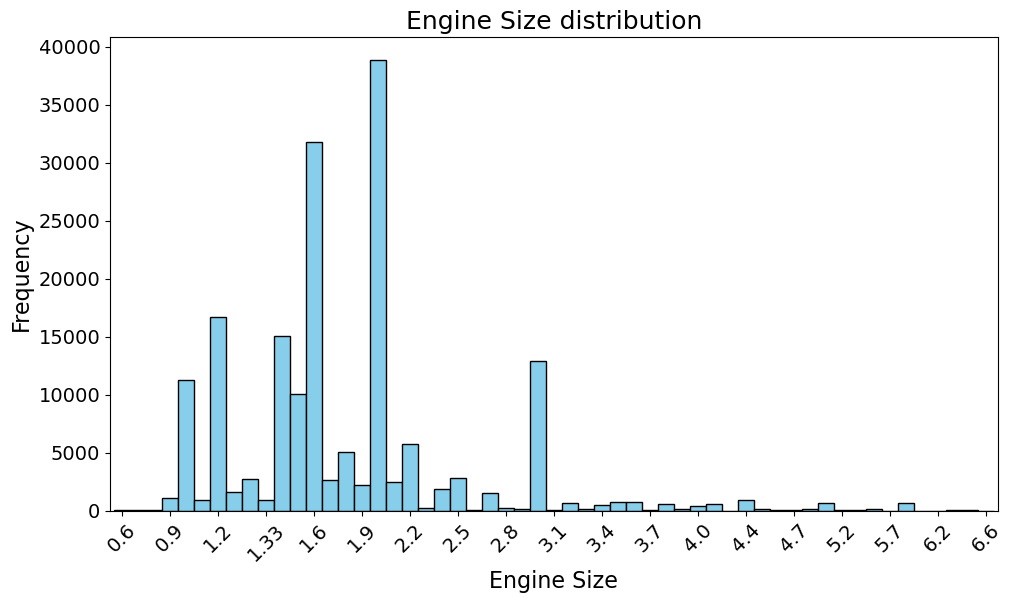

In [66]:
plot_distributions(df=engine_counts.sort_index(), feature="Engine Size", bins=100)

In [67]:
quartiles = np.percentile(full_data_df["Engine_size"], [25, 50, 75])
print(quartiles)

[1.4 1.6 2. ]


## Check if introduced shifts make a difference

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
def data_split(df: pd.DataFrame, nclasses: int, split: Union[float, int]) -> np.ndarray:
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  if isinstance(split, float):
    to_fill_size = (int(len(df)*split)-len(critical_ids))
  elif isinstance(split, int):
    to_fill_size = split - len(critical_ids)
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    # make sure that at least two instances of each class is available. If not, remove the singular classes
    if stratify is not None:
      valid_stratify_labels = stratify.value_counts()[stratify.value_counts() >= 2].index
      valid_stratify = stratify[stratify.isin(valid_stratify_labels)]
      invalid_part = stratify[~stratify.isin(valid_stratify_labels)]
    else:
      valid_stratify = stratify
      invalid_part = None

    if invalid_part is not None:
        valid_other_ids = other_ids[~np.isin(other_ids, invalid_part.index)]
    else:
        valid_other_ids = other_ids

    _, low_data_ids = train_test_split(valid_other_ids, test_size=to_fill_size, random_state=2023, stratify=valid_stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [70]:
def create_cutted_split(df: pd.DataFrame, desired_size: int, calc_ratio: bool = False) -> pd.DataFrame:
    nclasses = df["Genmodel_ID"].nunique()
    if desired_size >= len(df)-nclasses:
        print("Too little data.")
        return df.sample(n=desired_size, random_state=42).reset_index(drop=True)
         
    desired_size = min(desired_size, len(df)-1)
    x = desired_size / len(df) if calc_ratio else desired_size
    
    df_ids = data_split(df=df, nclasses=nclasses, split=x)
    cutted_df = df.loc[df['Adv_ID'].isin(df_ids)]
    return cutted_df

In [71]:
def visualize_tsne(dfs, labels, categorical_columns=None, n_components=2, random_state=42, sample_frac=0.2):
    # Add dataset labels
    for df, label in zip(dfs, labels):
        df['__source'] = label

    # Combine DataFrames
    combined = pd.concat(dfs).reset_index(drop=True)

    # Optional sampling
    sampled = combined.sample(frac=sample_frac, random_state=random_state).reset_index(drop=True)
    source_labels = sampled['__source']
    sampled = sampled.drop(columns='__source')

    # One-hot encode categorical columns if provided
    if categorical_columns:
        sampled = pd.get_dummies(sampled, columns=categorical_columns)

    # Run t-SNE
    tsne = TSNE(n_components=n_components, random_state=random_state)
    reduced = tsne.fit_transform(sampled)

    # Compute label sizes in sampled data
    label_counts = source_labels.value_counts()
    sorted_labels = label_counts.sort_values().index.tolist()  # smallest to largest

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    for label in sorted_labels:
        idx = source_labels == label
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label, alpha=0.6)
    plt.title('t-SNE Projection')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [77]:
continuous_columns = ['Adv_year', 'Adv_month', 'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num', 'Entry_price',  'Engine_size', 'Wheelbase','Height','Width','Length']
categorical_columns = ['Color', 'Bodytype', 'Gearbox', 'Fuel_type']
reorder_columns = categorical_columns + continuous_columns

diraa = "label"

original_train_df = pd.read_csv(os.path.join(SHIFTED_DIR, "too_small", diraa, "dvm_features_traincomplete_0.1.csv"), header=None)
original_train_01_df = pd.read_csv(os.path.join(SHIFTED_DIR, "too_small", diraa, "dvm_features_train_0.1.csv"), header=None)
original_train_09_df = pd.read_csv(os.path.join(SHIFTED_DIR, "too_small", diraa, "dvm_features_train_0.9.csv"), header=None)
original_train_001_df = pd.read_csv(os.path.join(SHIFTED_DIR, "too_small", diraa, "dvm_features_train_0.01.csv"), header=None)
original_train_099_df = pd.read_csv(os.path.join(SHIFTED_DIR, "too_small", diraa, "dvm_features_train_0.99.csv"), header=None)
original_val_df = pd.read_csv(os.path.join(SHIFTED_DIR, "too_small", diraa, "dvm_features_val_0.1.csv"), header=None)#.loc[:, reorder_columns]
original_test_df = pd.read_csv(os.path.join(SHIFTED_DIR, "too_small", diraa, "dvm_features_test_0.1.csv"), header=None)#.loc[:, reorder_columns]

display(len(original_train_df))
display(len(original_val_df))
display(len(original_test_df))

original_train_df.columns = reorder_columns
original_train_01_df.columns = reorder_columns
original_train_09_df.columns = reorder_columns
original_val_df.columns = reorder_columns
original_test_df.columns = reorder_columns

#visualize_tsne(dfs=[original_train_df, original_val_df, original_test_df], labels=["Train", "Val", "Test"], categorical_columns=categorical_columns)

28997

5000

4995

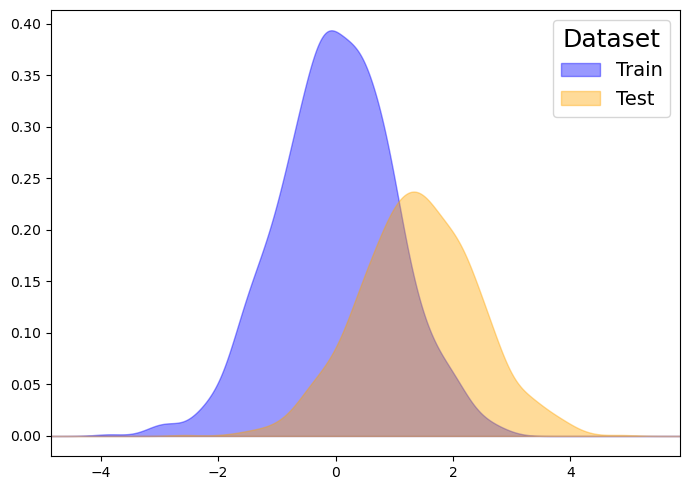

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate dummy data
train_data = np.random.normal(loc=0, scale=1, size=1000)
test_data = np.random.normal(loc=1.4, scale=1, size=1000)

xmin = min(train_data.min(), test_data.min()) - 1
xmax = max(train_data.max(), test_data.max()) + 1
x = np.linspace(xmin, xmax, 1000)

# KDE for training data
kde_train = gaussian_kde(train_data)
y_train = kde_train(x)

# KDE for test data
kde_test = gaussian_kde(test_data)
y_test = kde_test(x)

# Scale down test KDE height (e.g., reduce by 40%)
scale_factor = 0.6
y_test_scaled = y_test * scale_factor

# Overlapping plot function
def plot_overlapping_kdes(x, y1, y2, color1, color2):
    plt.figure(figsize=(7, 5))
    plt.fill_between(x, y1, color=color1, alpha=0.4, label='Train')
    plt.fill_between(x, y2, color=color2, alpha=0.4, label='Test')
    plt.xlim(xmin, xmax)
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)

    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.legend(title="Dataset", title_fontsize=18, fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot both KDEs overlapping
plot_overlapping_kdes(x, y_train, y_test_scaled, 'blue', 'orange')

In [281]:
def get_path(im_name: str):
    split = im_name.split('$$')
    path = os.path.join(FEATURES, split[0], split[1], split[2], split[3], im_name)
    assert os.path.exists(path)
    return path

def extract_data_point(df: pd.DataFrame, idx: int) -> tuple[pd.DataFrame, str]:
    datapoint = df.iloc[idx]
    image_path = datapoint["Image_name"]
    if "$$" in image_path:
        image_path = get_path(im_name=image_path)
    return pd.DataFrame(datapoint), image_path

def show_image(img_path: str) -> None:
    img = mpimg.imread(img_path)
    print(f"Image size: {img.shape}")  # (height, width, channels)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

/mnt/data/kgutjahr/datasets/DVM/images/Kia/Soul/2016/Red/Kia$$Soul$$2016$$Red$$43_12$$103$$image_0.jpg


,49726
Color,Red
Bodytype,Hatchback
Gearbox,Manual
Fuel_type,Diesel
Adv_year,2016
Adv_month,10
Reg_year,2016.0
Runned_Miles,6105
Price,12500
Seat_num,5.0


Image size: (300, 300, 3)


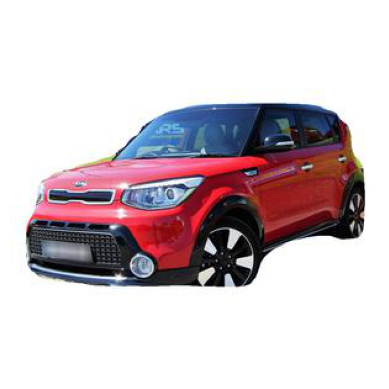

In [282]:
from random import randrange
datapoint, img_path = extract_data_point(df=full_data_df[full_data_df["Adv_year"] == 2016], idx=randrange(len(full_data_df[full_data_df["Adv_year"] == 2016])))
print(img_path)

display(datapoint.loc[reorder_columns])
show_image(img_path=img_path)